# How to Train YOLOv6 on a Custom Dataset

This tutorial is based on the [YOLOv6 repository](https://github.com/meituan/YOLOv6) (officially "MT-YOLOv6") by Meituan. This notebook shows training on **your own custom objects**. Many thanks to Meituan for putting this repository together.


### **Accompanying Blog Post**

We recommend that you follow along in this notebook while reading the blog post on [how to train YOLOv6](https://blog.roboflow.com/how-to-train-yolov6-on-a-custom-dataset/), concurrently.

### **Steps Covered in this Tutorial**

In this tutorial, we will walk through the steps required to train YOLOv6 on your custom objects. We use a [public chess pieces detection dataset](https://universe.roboflow.com/joseph-nelson/chess-pieces-new), which is open source and free to use. (There are 90,000+ more computer vision datasets [here](https://universe.roboflow.com/).)

To train our detector we take the following steps:

* Prepare our dataset in MT-YOLOv6 format
* Install MT-YOLOv6 dependencies
* Load custom dataset
* Run MT-YOLOv6 training
* Evaluate MT-YOLOv6 performance
* Visualize MT-YOLOv5 training data
* Run MT-YOLOv6 inference on test images
* OPTIONAL: Deployment
* OPTIONAL: Active Learning


### Easier Dataset Prep

This dataset was prepared using [Roboflow](https://roboflow.com), a set of tools developers use to build better computer vision models quickly and accurately. 100k+ developers use roboflow for (automatic) annotation, converting dataset formats (like to YOLOv6), training, deploying, and improving their datasets/models.

Members of the Roboflow community also share 60M+ images, 90,000+ projects, and 7,000+ pretrained models: https://universe.roboflow.com


#Install Dependencies

_(Remember to choose GPU in Runtime if not already selected. Runtime --> Change Runtime Type --> Hardware accelerator --> GPU)_

In [ ]:
# Download MT-YOLOv6 repository and install requirements
!git clone https://github.com/meituan/YOLOv6
%cd YOLOv6
!pip install -r requirements.txt

fatal: destination path 'YOLOv6' already exists and is not an empty directory.
/content/YOLOv6
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Prepare Custom Dataset

We need our dataset in the YOLOv6 format, which requires YOLO TXT annotations, organized directories, and a specific `.yaml` config file. 

- If you're following the custom chess dataset example, use the YOLOv6 format chess dataset export [here](https://universe.roboflow.com/joseph-nelson/chess-pieces-new/23/export).

- If you're preparing your own data, use the guide for creating, formatting, and exporting your custom dataset [here](https://blog.roboflow.com/how-to-train-yolov6-on-a-custom-dataset/).




**The YOLOv6 format is as follows:**

[YOLO TXT format](https://roboflow.com/formats/yolo-darknet-txt)
```
# class_id center_x center_y bbox_width bbox_height
1 0.408 0.30266666666666664 0.104 0.15733333333333333
```

Dataset directory format
```
# image directory
path/to/data/images/train/im0.jpg
path/to/data/images/val/im1.jpg
path/to/data/images/test/im2.jpg

# label directory
path/to/data/labels/train/im0.txt
path/to/data/labels/val/im1.txt
path/to/data/labels/test/im2.txt
```

`YAML` format

```
train: ./images/train
val: ./images/valid
test: ./images/test

nc: 12
names: ['black-bishop', 'black-king', 'black-knight', 'black-pawn', 'black-queen', 'black-rook', 'white-bishop', 'white-king', 'white-knight', 'white-pawn', 'white-queen', 'white-rook']

```

For a step-by-step on getting your data into this correct format, follow the blog post here: https://blog.roboflow.com/how-to-train-yolov6-on-a-custom-dataset/

# Download Correctly Formatted Custom Data

Next, we'll download our dataset in the right format. Use the `meituan/YOLOv6 PyTorch` export. Note that the Meituan implementation requires YOLO TXT annotations, a custom YAML file, and organized directories. The roboflow export writes this for us. (See [this guide](https://blog.roboflow.com/how-to-train-yolov6-on-a-custom-dataset/) for more details.)


![YOLOv6 export](https://i.imgur.com/W9IIZxr.gif)

In [ ]:
# REPLACE with your custom code snippet generated above to use your data

!pip install "roboflow>=0.2.11"

from roboflow import Roboflow
rf = Roboflow(api_key="chess-sample-only-api-key")                       
project = rf.workspace("joseph-nelson").project("chess-pieces-new")         
dataset = project.version(23).download("mt-yolov6")     



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Pillow-9.0.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.3 MB)
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to chess-pieces-new-23 in mt-yolov6:: 100%|██████████| 589/589 [00:01<00:00, 401.52it/s]


# Custom Training Details

There are a number of ways to fine tune training of YOLOv6, like custom configuration files for fine tuning, multi GPU support, and passing custom training arguments.


### Multi GPU Support

YOLOv6 supports single and multi GPU training.

Single GPU:
```
python tools/train.py --batch 256 --conf configs/yolov6s_finetune.py --data data/data.yaml --device 0
```

Multi GPU:
```
python -m torch.distributed.launch --nproc_per_node 4 tools/train.py --batch 256 --conf configs/yolov6s_finetune.py --data data/data.yaml --device 0,1,2,3
```

### Custom Configuration

YOLOv6 also supports creating a custom configuration file for training YOLOv6-n, YOLOv6-tiny, and YOLOv6s. (YOLOv6 m/l/x are coming soon.) You can also start training with a configuration that uses finetuning (e.g. `yolov6s_finetune.py` or starting from scratch (`yolov6s.py`). Finetuning will train faster though may not be as effective on unique datasets.

### Default Arguments
- --data-path, default='./data/coco.yaml', type=str, help='path of dataset')
- --conf-file, default='./configs/yolov6s.py', type=str, help='experiments description file')
- --img-size, type=int, default=640, help='train, val image size (pixels)')
- --batch-size, default=32, type=int, help='total batch size for all GPUs')
- --epochs, default=400, type=int, help='number of total epochs to run')
- --workers, default=8, type=int, help='number of data loading workers (default: 8)')
- --device, default='0', type=str, help='cuda device, i.e. 0 or 0,1,2,3 or cpu')
- --eval-interval, type=int, default=20, help='evaluate at every interval epochs')
- --eval-final-only, action='store_true', help='only evaluate at the final epoch')
- --heavy-eval-range, default=50,help='evaluating every epoch for last such epochs (can be jointly used with --eval-interval)')
- --check-images, action='store_true', help='check images when initializing datasets')
- --check-labels, action='store_true', help='check label files when initializing datasets')
- --output-dir, default='./runs/train', type=str, help='path to save outputs')
- --name, default='exp', type=str, help='experiment name, saved to output_dir/name')
- --dist_url, type=str, default="default url: tcp://127.0.0.1:8888")
- --gpu_count, type=int, default=0)
- --local_rank, type=int, default=-1, help='DDP parameter')
- --resume, type=str, default=None, help='resume the corresponding ckpt')


# Begin Custom Training

We're ready to start custom training.

NOTE: We will modify two of the YOLOv6 training defaults in our custom training example: `epochs` and `image-size`. We will adjust from 400 to 100 epochs in our example for speed. Similarly, we will adjust image size from 600x600 to 416x416, which is the default size for other YOLO models (and makes comparisons easier as well as training slightly faster).


In [ ]:
# run this cell to begin training
!python tools/train.py --batch 32 --conf configs/yolov6s.py --epochs 100 --img-size 416 --data {dataset.location}/data.yaml --device 0 

Using 1 GPU for training... 
training args are: Namespace(batch_size=32, check_images=False, check_labels=False, conf_file='configs/yolov6s.py', data_path='/content/YOLOv6/chess-pieces-new-23/data.yaml', device='0', dist_url='env://', epochs=100, eval_final_only=False, eval_interval=20, gpu_count=0, heavy_eval_range=50, img_size=416, local_rank=-1, name='exp', output_dir='./runs/train', rank=-1, resume=False, save_dir='runs/train/exp1', workers=8, world_size=1)

Train: Final numbers of valid images: 202/ labels: 202. 
0.0s for dataset initialization.
Convert to COCO format
100% 58/58 [00:00<00:00, 31791.64it/s]
Convert to COCO format finished. Resutls saved in chess-pieces-new-23/annotations/instances_valid.json
Val: Final numbers of valid images: 58/ labels: 58. 
0.1s for dataset initialization.
Model: Model(
  (backbone): EfficientRep(
    (stem): RepVGGBlock(
      (nonlinearity): ReLU(inplace=True)
      (se): Identity()
      (rbr_dense): Sequential(
        (conv): Conv2d(3, 32, 

# Evaluation

We can evaluate the performance of our custom training using the provided evalution script.

Note we can adjust the below custom arguments.

- --data, type=str, default='./data/coco.yaml', help='dataset.yaml path')
- -weights, type=str, default='./weights/yolov6s.pt', help='model.pt path(s)')
- --batch-size, type=int, default=32, help='batch size')
- --img-size, type=int, default=640, help='inference size (pixels)')
- --conf-thres, type=float, default=0.001, help='confidence threshold')
- --iou-thres, type=float, default=0.65, help='NMS IoU threshold')
- --task, default='val', help='val, or speed')
- --device, default='0', help='cuda device, i.e. 0 or 0,1,2,3 or cpu')
- --half, default=False, action='store_true', help='whether to use fp16 infer')
- --save_dir, type=str, default='runs/val/', help='evaluation save dir')
- -name, type=str, default='exp', help='save evaluation results to save_dir/name')

Similar to training, we will pass 416x416 images for evaluation as an example.

In [ ]:
# Run evaluation
!python tools/eval.py --data {dataset.location}/data.yaml --img-size 416 --weights runs/train/exp/weights/best_ckpt.pt --device 0 


Namespace(batch_size=32, conf_thres=0.001, data='/content/YOLOv6/chess-pieces-new-23/data.yaml', device='0', half=False, img_size=416, iou_thres=0.65, name='exp', save_dir='runs/val/', task='val', weights='runs/train/exp/weights/best_ckpt.pt')
Loading checkpoint from runs/train/exp/weights/best_ckpt.pt

Fusing model...
/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Switch model to deploy modality.
Model Summary: Params: 17.19M, Gflops: 18.63
Val: Checking formats of labels with 2 process(es): 
58 label(s) found, 0 label(s) missing, 0 label(s) empty, 0 invalid label files: 100% 58/58 [00:00<00:00, 3039.96it/s]
Convert to COCO format
100% 58/58 [00:00<00:00, 53162.07it/s]
Convert to COCO format finished. Resutls saved in chess-

# Inference

We can run inference on images of our custom trained model using the provided inference utility.

There are a number of arguments we can adjust:

- --weights, type=str, default='weights/yolov6s.pt', help='model path(s) for inference.')
- --source, type=str, default='data/images', help='the source path, e.g. image-file/dir.')
- --yaml, type=str, default='data/coco.yaml', help='data yaml file.')
- --img-size, type=int, default=640, help='the image-size(h,w) in inference size.')
- --conf-thres, type=float, default=0.25, help='confidence threshold for inference.')
- --iou-thres, type=float, default=0.45, help='NMS IoU threshold for inference.')
- --max-det, type=int, default=1000, help='maximal inferences per image.')
- --device, default='0', help='device to run our model i.e. 0 or 0,1,2,3 or cpu.')
- --save-txt, action='store_true', help='save results to *.txt.')
- --save-img, action='store_false', help='save visuallized inference results.')
- --classes, nargs='+', type=int, help='filter by classes, e.g. --classes 0, or --classes 0 2 3.')
- --agnostic-nms, action='store_true', help='class-agnostic NMS.')
- --project, default='runs/inference', help='save inference results to project/name.')
- -name, default='exp', help='save inference results to project/name.')
- --hide-labels, default=False, action='store_true', help='hide labels.')
- --hide-conf, default=False, action='store_true', help='hide confidences.')
- --half, action='store_true', help='whether to use FP16 half-precision inference.')

We need to pass our custom `.yaml` file so that our label names are correct. We will also pass our `/test` directory to run inference on all images in our test split. In addition, similar to training, we will pass 416x416 images for inference as an example.


In [ ]:
# infer on all images in our /test directory
!python tools/infer.py --yaml {dataset.location}/data.yaml --img-size 416 --weights runs/train/exp/weights/best_ckpt.pt --source {dataset.location}/images/test/ --device 0


Namespace(agnostic_nms=False, classes=None, conf_thres=0.25, device='0', half=False, hide_conf=False, hide_labels=False, img_size=416, iou_thres=0.45, max_det=1000, name='exp', project='runs/inference', save_img=True, save_txt=False, source='/content/YOLOv6/chess-pieces-new-23/images/test/', weights='runs/train/exp/weights/best_ckpt.pt', yaml='/content/YOLOv6/chess-pieces-new-23/data.yaml')
Save directory already existed
Loading checkpoint from runs/train/exp/weights/best_ckpt.pt

Fusing model...
/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Switch model to deploy modality.
100% 29/29 [00:02<00:00,  9.74it/s]
Results saved to runs/inference/exp


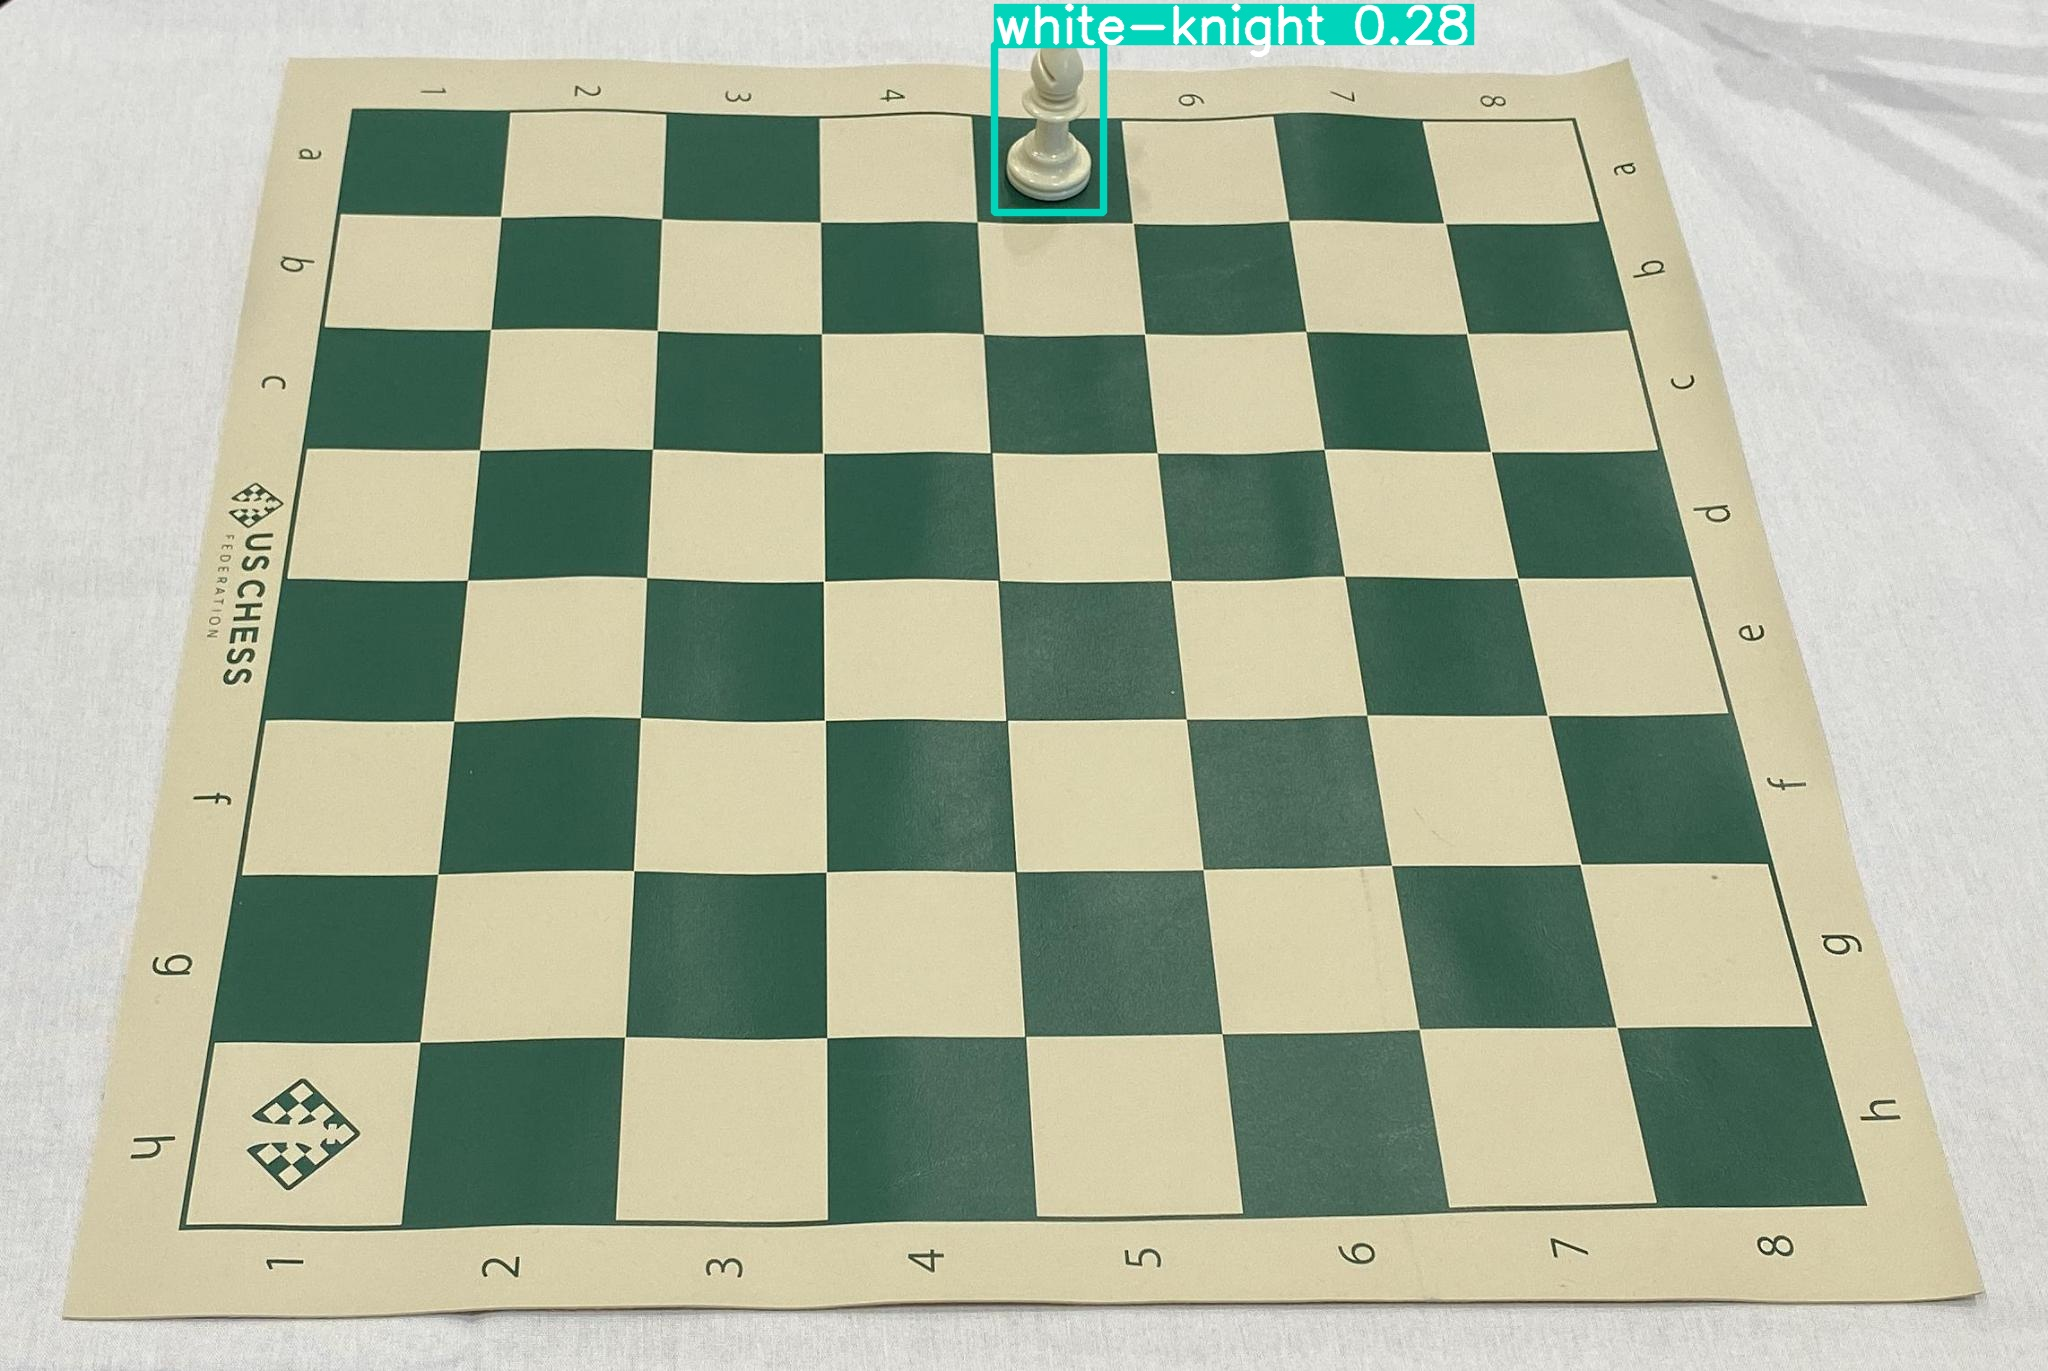

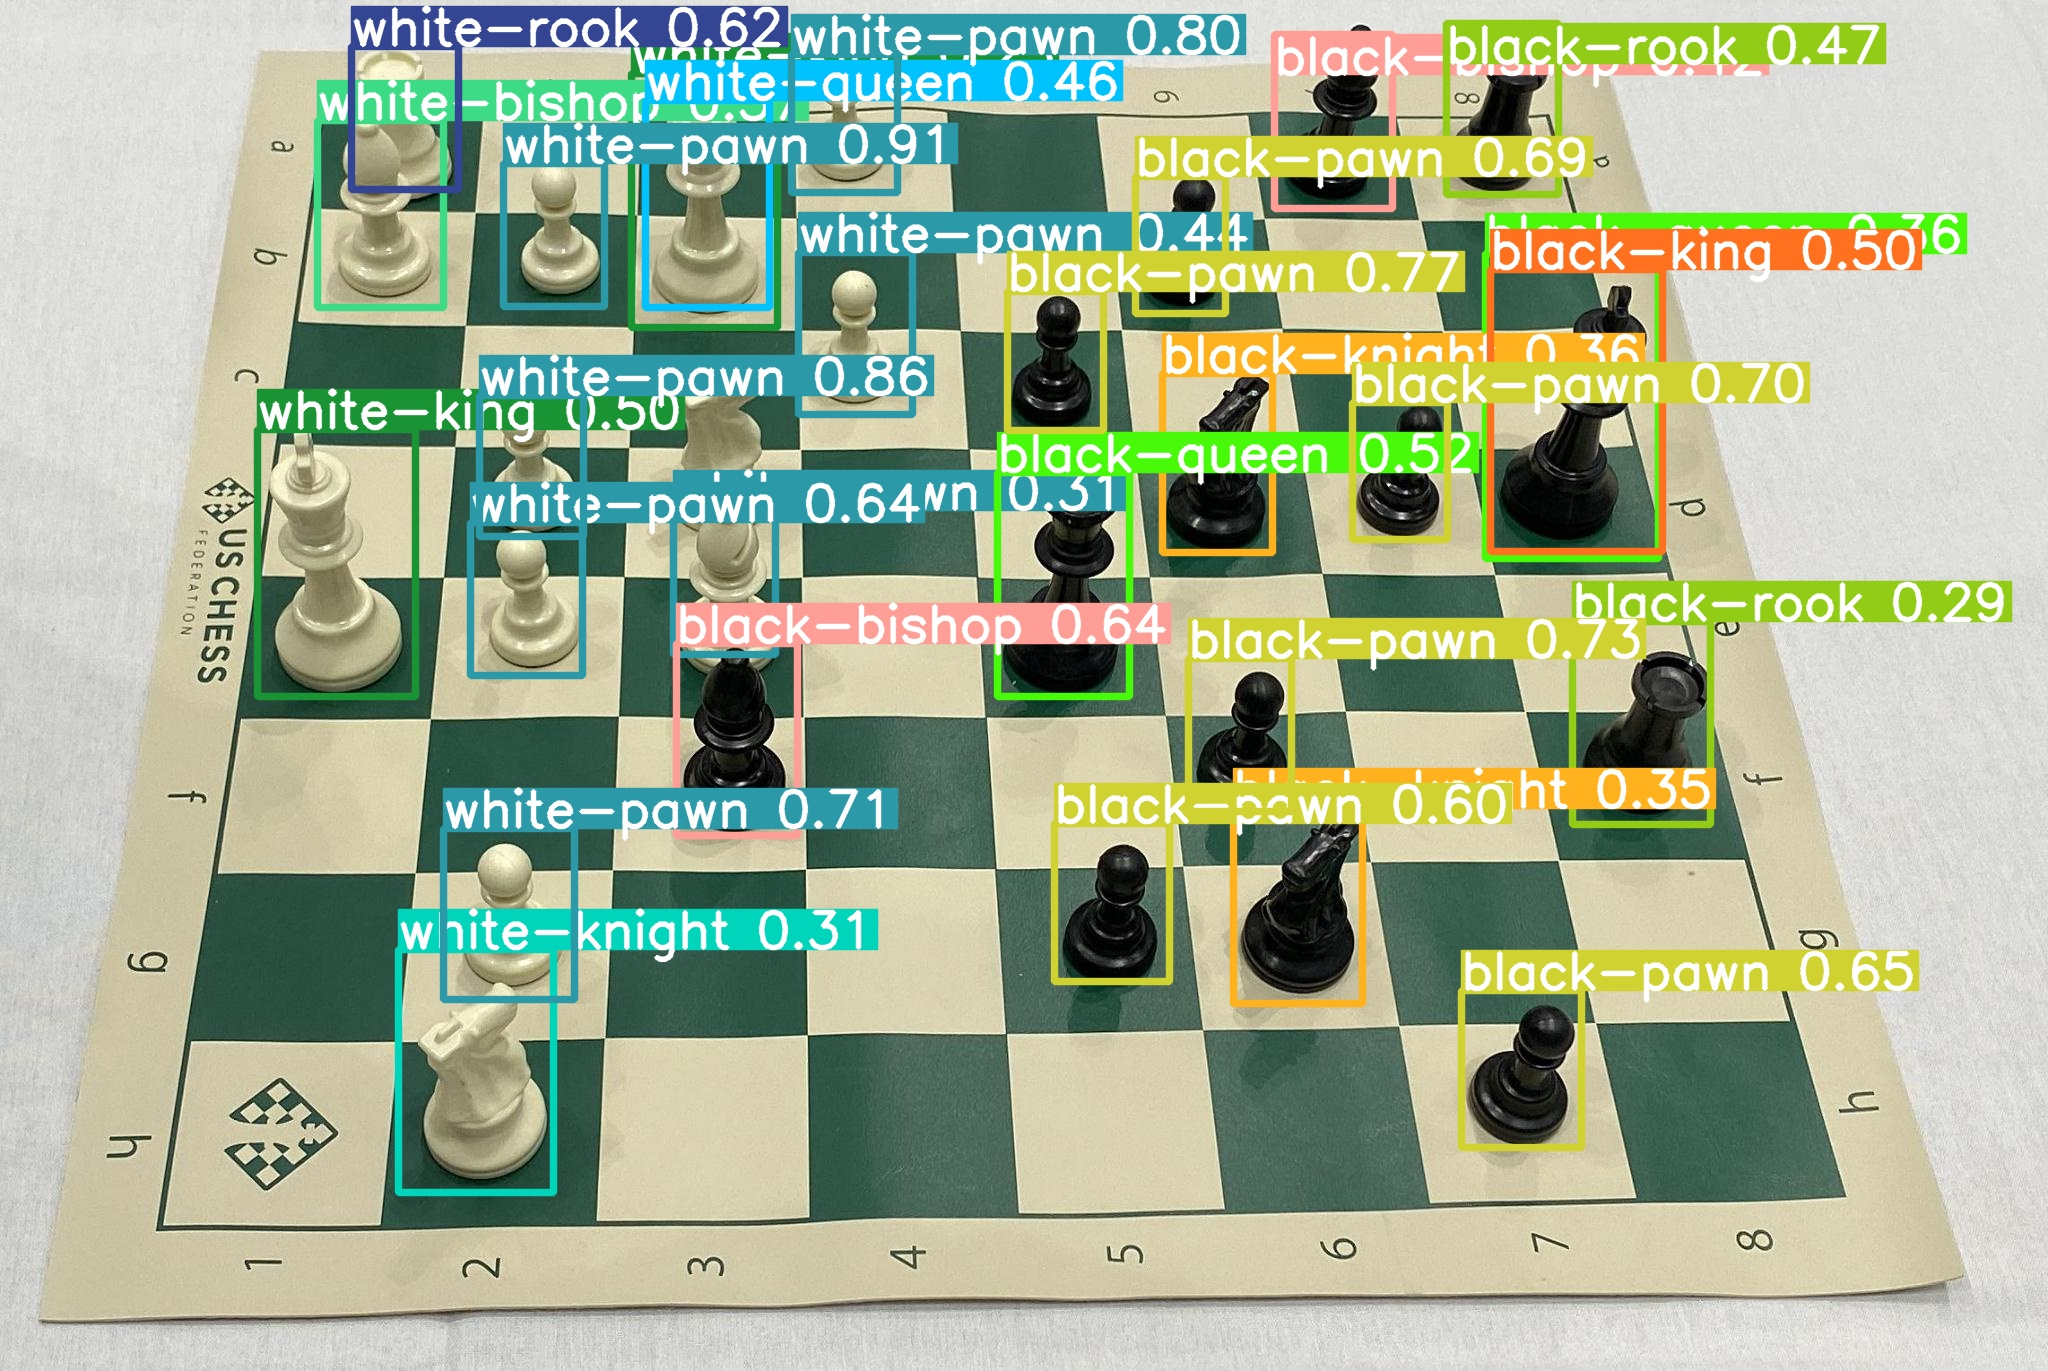

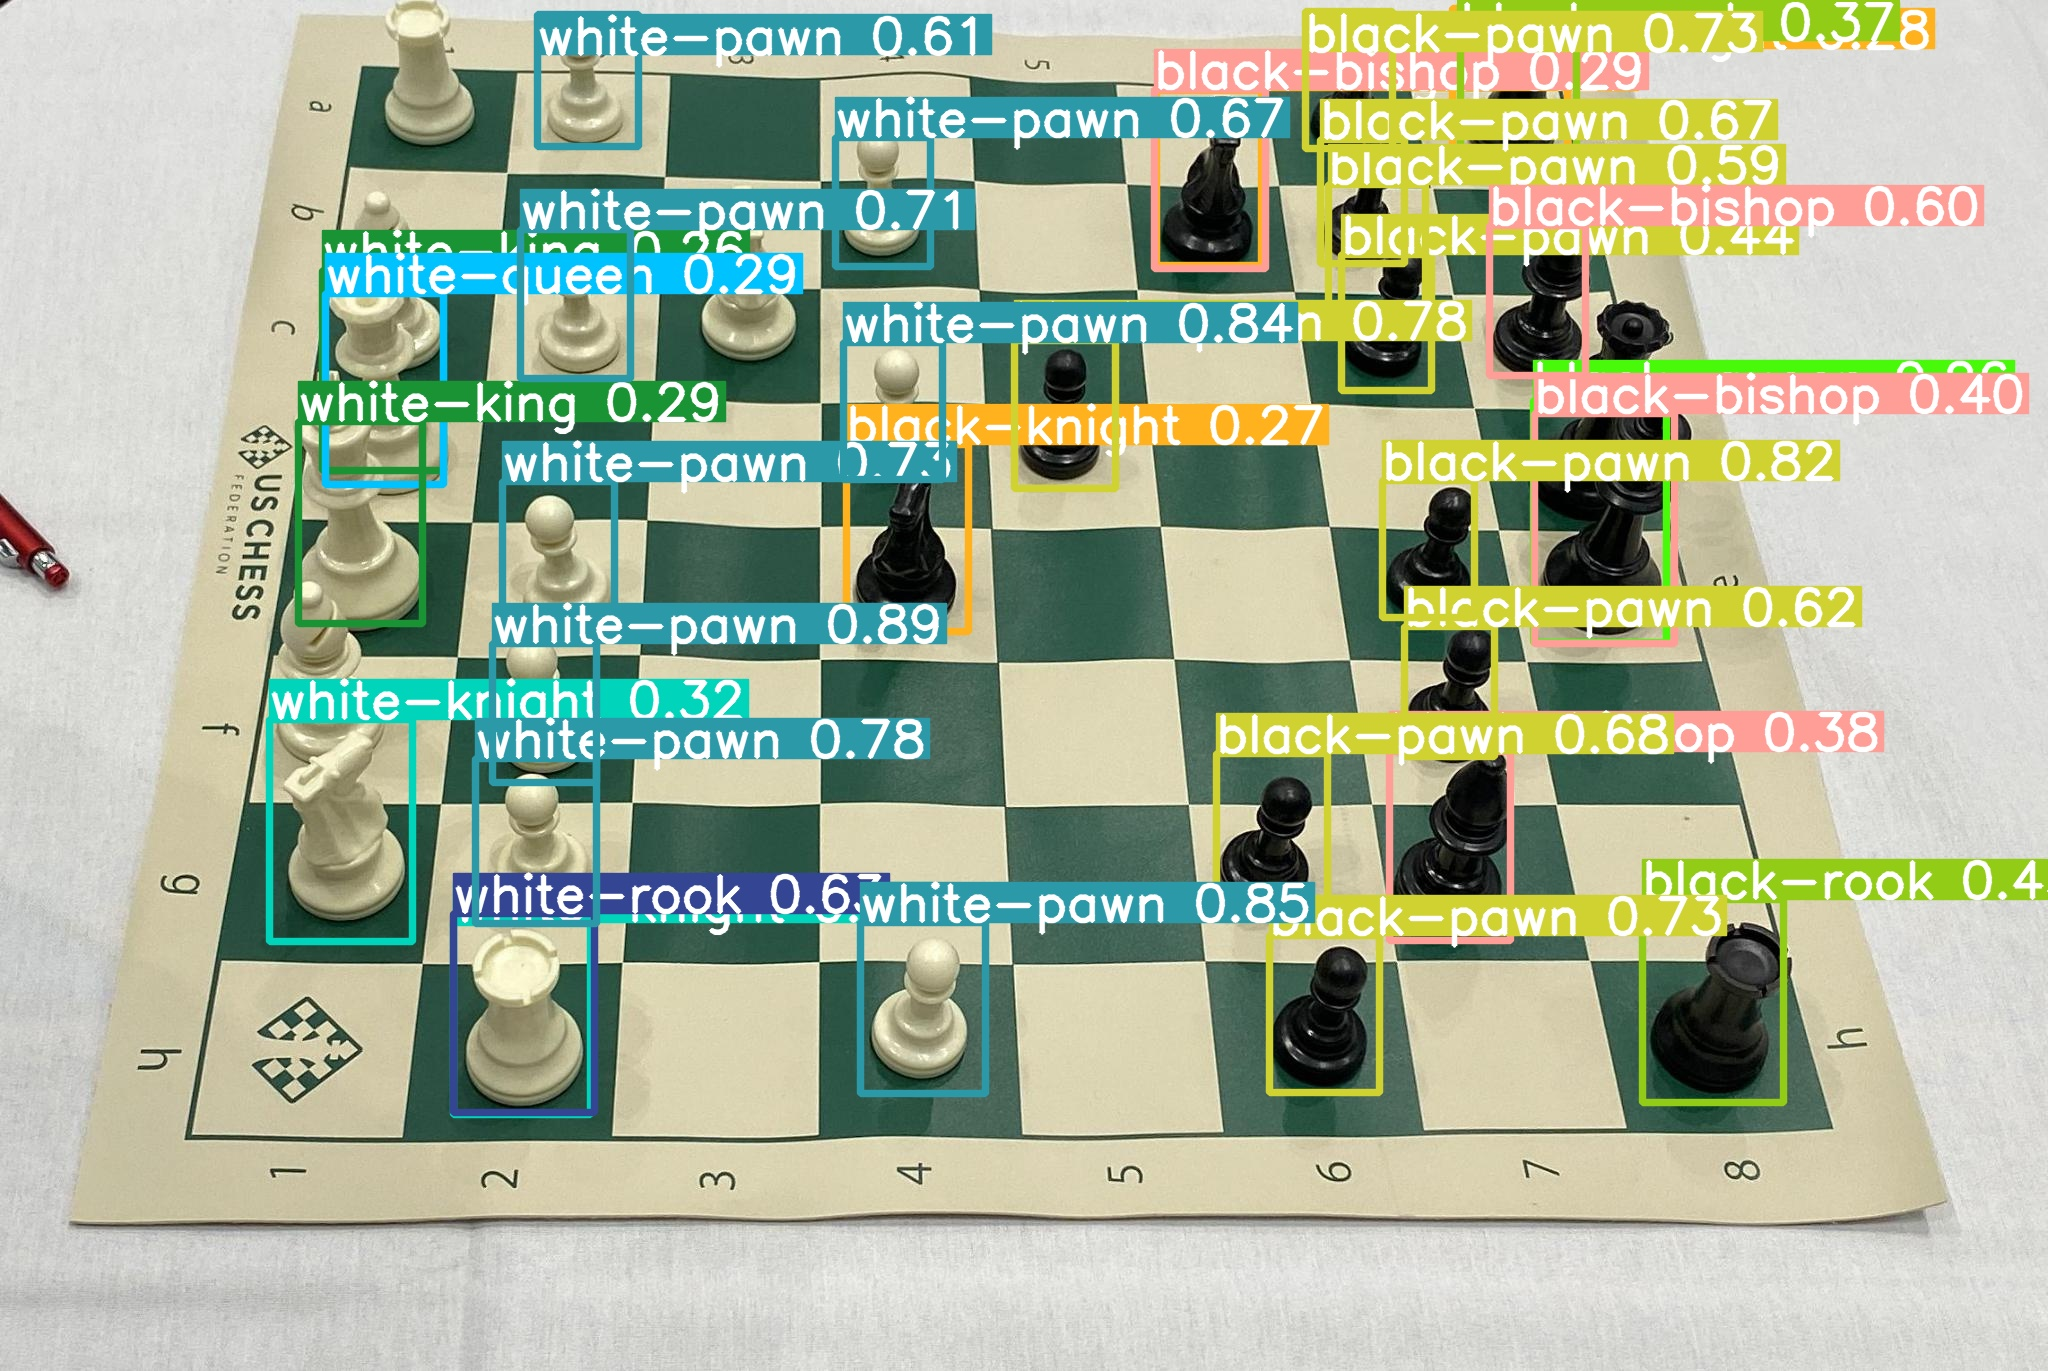

In [ ]:
# display test inference result images
import glob
from IPython.display import Image, display

i = 0
limit = 3 # max images to print
for imageName in glob.glob('./runs/inference/exp/*.jpg'): #assuming JPG
    if i < limit:
      display(Image(filename=imageName))
      print("\n\n")
    i = i + 1

# OPTIONAL: Deployment

There is a [utility included](https://github.com/meituan/YOLOv6/tree/main/deploy/ONNX) to export the model as ONNX format for deployment as well:
```
python deploy/ONNX/export_onnx.py --weights runs/train/exp/weights/best_ckpt.pt --device 0
```

# OPTIONAL: Active Learning Example

Once our first training run is complete, we should use our model to help identify which images are most problematic in order to investigate, annotate, and improve our dataset (and, therefore, model).

To do that, we can execute code that automatically uploads images back to our hosted dataset if the image is a specific class or below a given confidence threshold.


In [ ]:
# # setup access to your workspace
# rf = Roboflow(api_key="YOUR_API_KEY")                               # used above to load data
# inference_project =  rf.workspace().project("YOUR_PROJECT_NAME")    # used above to load data
# model = inference_project.version(1).model

# upload_project = rf.workspace().project("YOUR_PROJECT_NAME")

# print("inference reference point: ", inference_project)
# print("upload destination: ", upload_project)

In [ ]:
# # example upload: if prediction is below a given confidence threshold, upload it 

# confidence_interval = [10,70]                                   # [lower_bound_percent, upper_bound_percent]

# for prediction in predictions:                                  # predictions list to loop through
#   if(prediction['confidence'] * 100 >= confidence_interval[0] and 
#           prediction['confidence'] * 100 <= confidence_interval[1]):
        
#           # upload on success!
#           print(' >> image uploaded!')
#           upload_project.upload(image, num_retry_uploads=3)     # upload image in question

# Congrats! Happy training.

Hope you enjoyed this.